## The Framework of Hypothesis Testing

Hypothesis testing is a core concept in inferential statistics. It provides a structured way to make decisions when faced with uncertainty. A common application is **A/B testing**, where a "control" group is compared to a "treatment" group to determine if a change had a real effect. The fundamental question is always the same: "Is the difference I observed in my sample a real effect, or is it just a result of random sampling variability?"

The process begins with a **hypothesis** about a population parameter. For example, we might hypothesize that the mean annual compensation for a population of data scientists is $110,000.

We then take a sample from that population and calculate a **point estimate** (the sample mean). If our sample mean is very close to the hypothesized mean, we have no reason to doubt the hypothesis. However, if our sample mean is very far from the hypothesized value, we might conclude that our initial hypothesis was wrong.


### Using the Bootstrap Distribution to Estimate Variability

To decide what constitutes "far," we need to understand how much our sample mean is expected to vary by chance alone. The **standard error** quantifies this variability. As we've seen, we can estimate the standard error by generating a **bootstrap distribution** from our sample. The standard deviation of this bootstrap distribution is our best estimate of the standard error.

```python
import pandas as pd
import numpy as np

# Create a generic "sample" DataFrame
np.random.seed(42)
sample = pd.DataFrame({
    'compensation': np.random.normal(loc=120000, scale=50000, size=500)
})

# Generate a bootstrap distribution of the sample mean
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['compensation'].mean())

# The standard deviation of the bootstrap distribution is the standard error
standard_error = np.std(bootstrap_dist, ddof=1)
print(f"Estimated Standard Error: {standard_error:.2f}")
```


### The Z-Score: Standardizing the Difference

The **z-score** is a standardized test statistic that reframes the difference between our sample statistic and the hypothesized parameter in units of standard errors. This allows us to assess how "surprising" our sample result is.

The formula is:
$$z = \frac{\text{Sample Statistic} - \text{Hypothesized Parameter Value}}{\text{Standard Error}}$$

A z-score of 2.5 means our observed sample statistic is 2.5 standard errors away from the hypothesized value.

```python
# Calculate the z-score 

# Our hypothesis about the population
hypothesized_mean = 110000

# Our observed statistic from the sample
sample_mean = sample['compensation'].mean()

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error

print(f"Sample Mean: {sample_mean:.2f}")
print(f"Hypothesized Mean: {hypothesized_mean}")
print(f"Z-score: {z_score:.4f}")
```

### Interpreting the Z-Score

To determine if our z-score is large or small, we compare it to the **standard normal distribution**, which is a normal distribution with a mean of 0 and a standard deviation of 1. If our original hypothesis were true, we would expect our z-score to be a value that could plausibly come from this distribution (i.e., a value close to zero).

A common threshold for statistical significance is a z-score whose absolute value is greater than **1.96**. This value corresponds to the middle 95% of the standard normal distribution. A z-score outside this range is considered unlikely to have occurred by random chance alone if the hypothesis were true.

  * If `|z| > 1.96`, we typically **reject the hypothesis**. The evidence suggests the true population parameter is different from what was hypothesized.
  * If `|z| ≤ 1.96`, we **fail to reject the hypothesis**. The observed difference is small enough that it could plausibly be due to random sampling variability.

In our example, the calculated z-score is greater than 1.96, so we would reject the hypothesis that the true mean compensation is $110,000. Our sample provides strong evidence that the true mean is likely higher.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/887ec4bc2bcfd4195e7d3ad113168555f36d3afa/late_shipments.feather"
late_shipments = pd.read_feather(url)

### Calculating the sample mean
The late_shipments dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. The `late` columns denotes whether or not the part was delivered late. A value of `"Yes"` means that the part was delivered late, and a value of `"No"` means the part was delivered on time.

In [5]:
# Print the late_shipments dataset.
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


In [6]:
# Calculate the proportion of late shipments in the sample; that is, the mean cases where the late column is "Yes".
late_prop_samp = (late_shipments["late"] == "Yes").mean()

# Print the results
print(late_prop_samp)

0.061


### Calculating a z-score
Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis test that gave different answers if the variables were in Euros instead of US dollars would be of little value. Standardization avoids that.

One standardized value of interest in a hypothesis test is called a z-score. To calculate it, you need three numbers: the sample statistic (point estimate), the hypothesized statistic, and the standard error of the statistic (estimated from the bootstrap distribution).

In [7]:
# late_shipments_boot_distn is a bootstrap distribution of the proportion of late shipments, available as a list.
late_shipments_boot_distn = [
    np.mean(
        (
            late_shipments["late"].sample(len(late_shipments), replace=True).values
            == "Yes"
        )
    )
    for _ in range(5000)
]

In [8]:
# Hypothesize that the proportion of late shipments is 6%.
late_prop_hyp = 0.06

# Calculate the standard error from the standard deviation of the bootstrap distribution.
std_error = np.std(late_shipments_boot_distn, ddof=1)

# Calculate the z-score.
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Print z_score
print(z_score)

0.13328593106420544


## The Logic of Hypothesis Testing

Hypothesis testing is a formal procedure for making statistical decisions. The process is analogous to a criminal trial:

1.  There are two competing claims: the **null hypothesis ($H\_0$)** and the **alternative hypothesis ($H\_A$)**.
2.  We begin by assuming the null hypothesis is true, just as a defendant is presumed innocent.
3.  We collect evidence (our sample data).
4.  We determine if the evidence is strong enough ("beyond a reasonable doubt") to reject the null hypothesis in favor of the alternative.

  * **Null Hypothesis ($H\_0$)**: The hypothesis of no effect, no difference, or the status quo. It is the existing idea or baseline that we assume to be true.

      * *Example*: $H\_0$: The proportion of data scientists who started programming as children is 35%.

  * **Alternative Hypothesis ($H\_A$ or $H\_1$)**: The new "challenger" idea that a researcher wants to find evidence for.

      * *Example*: $H\_A$: The proportion of data scientists who started programming as children is greater than 35%.

### One-Tailed and Two-Tailed Tests

The wording of the alternative hypothesis determines which "tails" of the sampling distribution we are interested in. This determines the type of test we are performing.

| Alternative Hypothesis ($H_A$) | Test Type      | Question Asked                                                                 |
| :----------------------------- | :------------- | :----------------------------------------------------------------------------- |
| Parameter $\neq$ Hypothesized Value | **Two-tailed**  | Is the sample statistic surprisingly far from the hypothesis in *either* direction? |
| Parameter $>$ Hypothesized Value   | **Right-tailed**| Is the sample statistic surprisingly *high*?                                   |
| Parameter $<$ Hypothesized Value   | **Left-tailed** | Is the sample statistic surprisingly *low*?                                    |

In our example, since $H\_A$ is that the proportion is *greater than* 35%, we are performing a **right-tailed test**.

### The P-Value: Quantifying "Surprise"

The **p-value** is the core of the hypothesis test. It is a single number that quantifies how surprising our sample result is, assuming the null hypothesis is correct.

**Formal Definition**: The p-value is the probability of obtaining a test statistic *at least as extreme* as the one calculated from the sample, given that the null hypothesis is true.

Visually, the p-value is the area in the tail(s) of the null distribution, starting from your observed test statistic.

**Interpretation**:

  * **Small p-value (e.g., p \< 0.05)**: The observed data is very unlikely to have occurred by random chance if the null hypothesis were true. This provides strong evidence *against* $H\_0$ and leads us to **reject the null hypothesis**.
  * **Large p-value (e.g., p ≥ 0.05)**: The observed data is plausible under the null hypothesis. We do not have enough evidence to reject the null hypothesis, so we **fail to reject the null hypothesis**. We never "accept" the null hypothesis; we only conclude that there is not sufficient evidence to overturn it.

### Calculating P-Values from a Z-Score

Once we have a z-score, we can use the **Cumulative Distribution Function (CDF)** of the standard normal distribution to find the p-value. The `scipy.stats.norm.cdf()` function calculates the area under the curve to the left of a given z-score.

  * **Right-tailed test**: The p-value is the area to the *right* of the z-score.
      * `p_value = 1 - norm.cdf(z_score)`
  * **Left-tailed test**: The p-value is the area to the *left* of the z-score.
      * `p_value = norm.cdf(z_score)`
  * **Two-tailed test**: The p-value is the area in both tails combined. We find the area in the more extreme tail and double it.
      * `p_value = 2 * (1 - norm.cdf(abs(z_score)))`

### A Complete Example

Let's complete our hypothesis test from the previous topic.

```python
import pandas as pd
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topic)
# Assume we have a sample, a hypothesis, and have calculated the z-score.
np.random.seed(42)
sample = pd.DataFrame({'is_child_coder': np.random.choice([True, False], 500, p=[0.4, 0.6])})
sample_prop = sample['is_child_coder'].mean()
hypothesized_prop = 0.35

# Generate bootstrap distribution to get standard error
bootstrap_dist = []
for i in range(5000):
    bootstrap_sample = sample.sample(frac=1, replace=True, random_state=i)
    bootstrap_dist.append(bootstrap_sample['is_child_coder'].mean())
std_error = np.std(bootstrap_dist, ddof=1)

# Calculate z-score
z_score = (sample_prop - hypothesized_prop) / std_error

print(f"Sample Proportion: {sample_prop:.4f}")
print(f"Hypothesized Proportion: {hypothesized_prop}")
print(f"Standard Error: {std_error:.4f}")
print(f"Z-score: {z_score:.4f}")

# 2. State Hypotheses and Define Test Type
# H0: The true proportion is 0.35.
# HA: The true proportion is greater than 0.35.
# This is a right-tailed test.

# 3. Calculate the p-value
# For a right-tailed test, we calculate the area to the right of our z-score.
p_value = 1 - norm.cdf(z_score)
print(f"\nP-value: {p_value:.6f}")

# 4. Make a Statistical Decision 
# We compare the p-value to a significance level (alpha), typically 0.05.
alpha = 0.05
if p_value < alpha:
    print(f"Since p-value ({p_value:.6f}) < alpha ({alpha}), we reject the null hypothesis.")
else:
    print(f"Since p-value ({p_value:.6f}) >= alpha ({alpha}), we fail to reject the null hypothesis.")
```

Because our p-value is very small, we reject the null hypothesis. Our sample provides strong statistical evidence that the true proportion of data scientists who started coding as children is likely greater than 35%.

In [9]:
from scipy.stats import norm

# Calculate the z-score of late_prop_samp.
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Calculate the p-value for the z-score, using a right-tailed test.
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.4469836268541092


## The Significance Level ($\alpha$): Defining the Threshold

The **p-value** quantifies the evidence against the null hypothesis ($H_0$). A small p-value means the observed sample data is very unlikely if the null hypothesis were true. But how small is "small enough" to reject $H_0$?

This cutoff point is the **significance level**, denoted by the Greek letter **$\alpha$ (alpha)**. It represents the threshold for our "beyond a reasonable doubt" criterion.

* **Definition**: The significance level, $\alpha$, is the probability of rejecting the null hypothesis when it is, in fact, true (a Type I error).
* **Common Values**: Typical values for $\alpha$ are 0.1 (10%), 0.05 (5%), and 0.01 (1%). The most widely used standard in many fields is $\alpha = 0.05$.
* **Decision Rule**: The value of $\alpha$ must be chosen *before* conducting the hypothesis test to avoid bias. The decision is then made by a direct comparison:
        * If $p \leq \alpha$, we **reject the null hypothesis**. The result is statistically significant.
        * If $p > \alpha$, we **fail to reject the null hypothesis**. The result is not statistically significant.


### The Relationship Between Confidence Intervals and Significance Tests

Confidence intervals and hypothesis tests are two sides of the same coin; they are different ways of performing statistical inference on the same underlying data. There is a direct duality between them:

A **two-tailed** hypothesis test with a significance level of $\alpha$ is equivalent to checking if the hypothesized parameter value falls **outside** the corresponding $1 - \alpha$ confidence interval.

* If $\alpha = 0.05$, we use a $1 - 0.05 = 0.95$, or **95% confidence interval**.
* **Decision Rule**:
        * If the hypothesized parameter value falls **outside** the 95% confidence interval, we **reject the null hypothesis**.
        * If the hypothesized parameter value falls **inside** the 95% confidence interval, we **fail to reject the null hypothesis**.

This provides a more intuitive, graphical way to interpret the result of a hypothesis test.

### Types of Errors in Hypothesis Testing

Because our decision is based on a sample, not the entire population, we can never be 100% certain about the true state of the world. Our statistical decision can sometimes be wrong. There are two types of errors we can make:

|                       | **True State: $H_0$ is True**         | **True State: $H_A$ is True**         |
|-----------------------|:--------------------------------------:|:--------------------------------------:|
| **Fail to Reject $H_0$** | Correct Decision<br>(True Negative)     | **Type II Error**<br>(False Negative)  |
| **Reject $H_0$**         | **Type I Error**<br>(False Positive)   | Correct Decision<br>(True Positive)    |

- **Type I Error (False Positive)**: Rejecting the null hypothesis when it is actually true. We conclude there is an effect when, in reality, there is none. The probability of making a Type I error is equal to our chosen significance level, $\alpha$.
- **Type II Error (False Negative)**: Failing to reject the null hypothesis when it is actually false. We conclude there is no effect when, in reality, there is one. The probability of a Type II error is denoted by $\beta$ (beta).


### A Complete Example

Let's tie these concepts together with a complete example, from calculating the p-value to making a decision and considering the confidence interval.

```python
import numpy as np
from scipy.stats import norm

# 1. Setup (from previous topics) 
# Assume we have a sample, a hypothesis, and have calculated the necessary statistics.
sample_mean = 119500
hypothesized_mean = 115000
standard_error = 2300
alpha = 0.05 # Our pre-defined significance level

# 2. Perform the Hypothesis Test (p-value approach)
# H0: The true mean is 115000.
# HA: The true mean is not 115000 (a two-tailed test).

# Calculate the z-score
z_score = (sample_mean - hypothesized_mean) / standard_error
# Calculate the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

# Make a decision
if p_value < alpha:
    print(f"Decision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}). The result is statistically significant.")
else:
    print(f"Decision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")

# 3. Perform the Hypothesis Test (Confidence Interval approach) 
# For alpha = 0.05, we need a 95% confidence interval.
# We will use the standard error method to construct it.
confidence_level = 1 - alpha # 0.95
lower_quantile = (1 - confidence_level) / 2 # 0.025
upper_quantile = 1 - lower_quantile # 0.975

# Calculate the bounds
lower_bound = norm.ppf(lower_quantile, loc=sample_mean, scale=standard_error)
upper_bound = norm.ppf(upper_quantile, loc=sample_mean, scale=standard_error)

print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

# Make a decision
if not (lower_bound <= hypothesized_mean <= upper_bound):
    print(f"Decision: Reject H0, because the hypothesized mean ({hypothesized_mean}) is outside the confidence interval.")
else:
    print(f"Decision: Fail to reject H0, because the hypothesized mean ({hypothesized_mean}) is inside the confidence interval.")

```

Both approaches lead to the same conclusion. Because our p-value is less than our significance level of 0.05, and equivalently, because the hypothesized mean of 115,000 falls outside our calculated 95% confidence interval, we reject the null hypothesis. We have statistically significant evidence that the true mean is different from 115,000. If we were wrong in this conclusion (a Type I error), it would mean the true mean really was 115,000, and we were misled by an unusually high sample mean.

In [10]:
# Calculate a 95% confidence interval from late_shipments_boot_distn using the quantile method, labeling the lower and upper intervals lower and upper.
lower = np.quantile(late_shipments_boot_distn, 0.015)
upper = np.quantile(late_shipments_boot_distn, 0.975)

# Print the confidence interval
print((lower, upper))

(np.float64(0.045), np.float64(0.076))


## The Two-Sample Problem

A common analytical task is to compare a continuous numerical variable across two distinct groups defined by a categorical variable. For example, we might want to know:

  * Is the average salary different for employees who have a certification versus those who do not?
  * Is the average blood pressure lower for a group taking a new drug compared to a group taking a placebo?

This setup, where we compare the means of two independent groups, is the basis for the two-sample t-test.



### Formulating hypotheses for a two-sample test

Let $\mu_1$ denote the population mean of Group 1 and $\mu_2$ that of Group 2.

* **Null hypothesis ($H_0$)** — no difference between population means:  
  $H_0: \mu_1 = \mu_2$  
  or equivalently  
  $H_0: \mu_1 - \mu_2 = 0$

* **Alternative hypothesis ($H_A$)** — actual difference exists (choose tail based on research question):
  * *Two-tailed test* (any difference):  
    $H_A: \mu_1 \neq \mu_2$
  * *Right-tailed test* (Group 1 > Group 2):  
    $H_A: \mu_1 > \mu_2$
  * *Left-tailed test* (Group 1 < Group 2):  
    $H_A: \mu_1 < \mu_2$



### The t‑statistic

The test statistic for comparing two means is the **t‑statistic**. It standardises the difference between the two sample means into a single number, accounting for the variability within each sample. The generic form of a standardised test statistic is

$$
\text{Test Statistic} = \frac{\text{Observed Sample Statistic} \, - \, \text{Hypothesised Population Parameter}}{\text{Standard Error of the Statistic}}
$$

### Two-Sample t-Test Formula

The t-statistic for a two-sample test is calculated as:

$$ t = \frac{(\bar{x}_1 - \bar{x}_2) - (\mu_1 - \mu_2)}{\text{SE}(\bar{x}_1 - \bar{x}_2)} $$

where:
- $\bar{x}_1$ and $\bar{x}_2$ are the sample means
- $\mu_1$ and $\mu_2$ are the population means

The standard error of the difference between two independent means is:

$$ \text{SE}(\bar{x}_1 - \bar{x}_2) = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} $$

where:
- $s_1$ and $s_2$ are the sample standard deviations
- $n_1$ and $n_2$ are the sample sizes

#### Under the Null Hypothesis ($H_0$)

When assuming $H_0$ is true ($\mu_1 - \mu_2 = 0$), the formula simplifies to:

$$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\dfrac{s_1^2}{n_1} + \dfrac{s_2^2}{n_2}}} $$

This t-value measures how many standard errors the observed difference ($\bar{x}_1 - \bar{x}_2$) lies from the hypothesized difference of zero.

### A Complete Calculation in Python

Let's walk through the calculation of the t-statistic for a two-sample problem.

```python
import pandas as pd
import numpy as np

# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Step 1: Calculate Groupwise Summary Statistics 
# Use .groupby() and .agg() to get mean, std, and count for each group
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
print(summary_stats)

# Extract the individual statistics
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Step 2: Calculate the t-statistic 
# Numerator: Difference in sample means
numerator = mean_group1 - mean_group2

# Denominator: Standard error of the difference
denominator = np.sqrt(
    (std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2)
)

# Final t-statistic
t_statistic = numerator / denominator

print(f"t-statistic: {t_statistic:.4f}")
```

This calculated t-statistic would then be used to find a p-value, allowing us to make a formal conclusion about our hypothesis. A larger absolute t-statistic suggests a greater difference between the groups relative to their internal variability, providing stronger evidence against the null hypothesis.

#### Two-Sample t-Test Statistic

The test statistic for comparing shipment weights:

$$ t = \frac{\bar{x}_{\text{no}} - \bar{x}_{\text{yes}}}{\sqrt{ \frac{s_{\text{no}}^2}{n_{\text{no}}} + \frac{s_{\text{yes}}^2}{n_{\text{yes}}} }} $$

Where:
- $\bar{x}_{\text{no}}$: Mean weight of on-time shipments
- $\bar{x}_{\text{yes}}$: Mean weight of late shipments
- $s_{\text{no}}$: Standard deviation of on-time shipments
- $s_{\text{yes}}$: Standard deviation of late shipments
- $n_{\text{no}}$: Number of on-time shipments
- $n_{\text{yes}}$: Number of late shipments

### Research Context
While trying to determine why some shipments are late, you may wonder if the weight of shipments that were **on time** is less than the weight of shipments that were **late**. 

The analysis uses:
- `late_shipments` dataset split into:
  - "no" group (`late == "No"`)
  - "yes" group (`late == "Yes"`)
- Weight measurements from `weight_kilograms` variable



In [11]:
late_no = late_shipments[late_shipments["late"] == "No"]
late_yes = late_shipments[late_shipments["late"] == "Yes"]
xbar_no = np.mean(late_no["weight_kilograms"])
xbar_yes = np.mean(late_yes["weight_kilograms"])
s_no = np.std(late_no["weight_kilograms"], ddof=1)
s_yes = np.std(late_yes["weight_kilograms"], ddof=1)
n_no = len(late_no)
n_yes = len(late_yes)

In [12]:
# Calculate the numerator of the test statistic
# This is the observed difference in mean weights between on-time ("no") and late ("yes") shipments
# A negative value means on-time shipments are lighter on average
numerator = xbar_no - xbar_yes

# Calculate the denominator (standard error) for independent samples
# Formula: sqrt(s_no^2 / n_no + s_yes^2 / n_yes)
# s_no**2 and s_yes**2 are the sample variances for each group
# n_no and n_yes are the sample sizes for each group
denominator = np.sqrt((s_no**2 / n_no) + (s_yes**2 / n_yes))

# Calculate the t-statistic: standardized difference in means
# t_stat tells us how many standard errors the observed difference is from zero (the null hypothesis)
t_stat = numerator / denominator

# Print the test statistic
print(t_stat)

-2.3936661778766433


Interpretation:
1) A negative t-statistic indicates on-time shipments are lighter than late shipments.
2) The magnitude shows how significant this difference is relative to sample variability.

## The t-distribution: A Family of Curves

While a z-statistic follows the standard normal distribution, a **t-statistic** follows a **t-distribution**. Like the normal distribution, a t-distribution is bell-shaped and centered at zero. However, it has a key difference: **it has fatter tails**.

This means that a t-distribution has more probability in its tails, reflecting the increased uncertainty we have when we use a sample standard deviation (`s`) to estimate a population standard deviation ($\sigma$).

The t-distribution is not a single distribution but a **family of distributions**. The exact shape of a particular t-distribution is defined by a single parameter: the **degrees of freedom (df)**.

  * For a small number of degrees of freedom, the tails are very fat.
  * As the degrees of freedom increase, the t-distribution's tails become thinner, and it converges towards the standard normal distribution. A t-distribution with infinite degrees of freedom is identical to the standard normal distribution.

### Calculating Degrees of Freedom

In statistics, **degrees of freedom** represent the number of independent values in a calculation that are free to vary. For an independent two-sample t-test, the degrees of freedom are calculated based on the sample sizes of the two groups. The standard formula is:

$$df = n_1 + n_2 - 2$$

Where $n\_1$ and $n\_2$ are the sample sizes of Group 1 and Group 2, respectively. The logic is that we start with $n\_1 + n\_2$ total observations and lose one degree of freedom for each of the two sample means we must estimate from the data.


### Calculating the p-value from a t-statistic

Once you have the t-statistic and degrees of freedom, calculate the p-value using the t-distribution's Cumulative Distribution Function (CDF). The `scipy.stats` library provides `t.cdf()` (analogous to `norm.cdf()` for z-tests).

The calculation depends on the alternative hypothesis:

* **Right-tailed test** ($H_A: \mu_1 > \mu_2$):  
  p-value = area to the *right* of t-statistic  
  ```python
  p_value = 1 - t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Left-tailed test** ($H_A: \mu_1 < \mu_2$):  
  p-value = area to the *left* of t-statistic  
  ```python
  p_value = t.cdf(t_stat, df=degrees_of_freedom)
  ```

* **Two-tailed test** ($H_A: \mu_1 \neq \mu_2$):  
  p-value = combined area in both tails  
  ```python
  p_value = 2 * (1 - t.cdf(abs(t_stat), df=degrees_of_freedom))
  ```

### A Complete Example

Let's complete the hypothesis test from the previous topic by calculating the p-value from our t-statistic and making a statistical decision.

```python
import pandas as pd
import numpy as np
from scipy.stats import t

# 1. Setup (from previous topic)
# Create a generic, reproducible dataset
np.random.seed(42)
group1_data = np.random.normal(loc=110, scale=30, size=100)
group2_data = np.random.normal(loc=100, scale=30, size=150)
df = pd.DataFrame({
    'group': ['Group 1'] * 100 + ['Group 2'] * 150,
    'value': np.concatenate([group1_data, group2_data])
})

# Calculate groupwise summary statistics
summary_stats = df.groupby('group')['value'].agg(['mean', 'std', 'count'])
mean_group1 = summary_stats.loc['Group 1', 'mean']
mean_group2 = summary_stats.loc['Group 2', 'mean']
std_group1 = summary_stats.loc['Group 1', 'std']
std_group2 = summary_stats.loc['Group 2', 'std']
n_group1 = summary_stats.loc['Group 1', 'count']
n_group2 = summary_stats.loc['Group 2', 'count']

# Calculate the t-statistic
numerator = mean_group1 - mean_group2
denominator = np.sqrt((std_group1 ** 2 / n_group1) + (std_group2 ** 2 / n_group2))
t_statistic = numerator / denominator

# 2. State Hypotheses and Define Test
# H0: The mean of Group 1 is equal to the mean of Group 2 (μ1 = μ2)
# HA: The mean of Group 1 is greater than the mean of Group 2 (μ1 > μ2)
# This is a right-tailed test.
alpha = 0.05 # Significance level

# 3. Calculate Degrees of Freedom
degrees_of_freedom = n_group1 + n_group2 - 2

# 4. Calculate the p-value 
# For a right-tailed test, we calculate the area to the right of our t-statistic.
p_value = 1 - t.cdf(t_statistic, df=degrees_of_freedom)

print(f"t-statistic: {t_statistic:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print(f"P-value: {p_value:.4f}")

# 5. Make a Statistical Decision 
if p_value < alpha:
    print(f"\nDecision: Reject H0, because p ({p_value:.4f}) < alpha ({alpha}).")
else:
    print(f"\nDecision: Fail to reject H0, because p ({p_value:.4f}) >= alpha ({alpha}).")
```

This complete workflow, from stating hypotheses to calculating the t-statistic and degrees of freedom to finally finding the p-value, allows for a rigorous statistical comparison between the means of two groups.

In [13]:
from scipy.stats import t

# Calculate the degrees of freedom
degrees_of_freedom = n_no + n_yes - 2

# Calculate the p-value from the test stat
p_value = t.cdf(t_stat, df=degrees_of_freedom)

# Print the p_value
print(p_value)

0.008432382146249523


In [14]:
url = "https://assets.datacamp.com/production/repositories/5982/datasets/4ab6431d773d1fe659ac120b4b49a1b525a76712/dem_votes_potus_12_16.feather"
sample_dem_data = pd.read_feather(url)
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


In [18]:
# Create a new diff column containing the percentage of votes for the democratic candidate in 2012 minus the percentage of votes for the democratic candidate in 2016.

sample_dem_data["diff"] = (
    sample_dem_data["dem_percent_12"] - sample_dem_data["dem_percent_16"]
)

# Find the mean of the diff column
xbar_diff = sample_dem_data["diff"].mean()

# Find the standard deviation of the diff column
s_diff = sample_dem_data["diff"].std()

# Print s_diff
print(s_diff)

5.040139140132317


In [24]:
sample_dem_data.head()

,state,county,dem_percent_12,dem_percent_16,diff
0,Alabama,Bullock,76.305900,74.946921,1.358979
1,Alabama,Chilton,19.453671,15.847352,3.606319
2,Alabama,Clay,26.673672,18.674517,7.999155
3,Alabama,Cullman,14.661752,10.028252,4.633500
4,Alabama,Escambia,36.915731,31.020546,5.895185


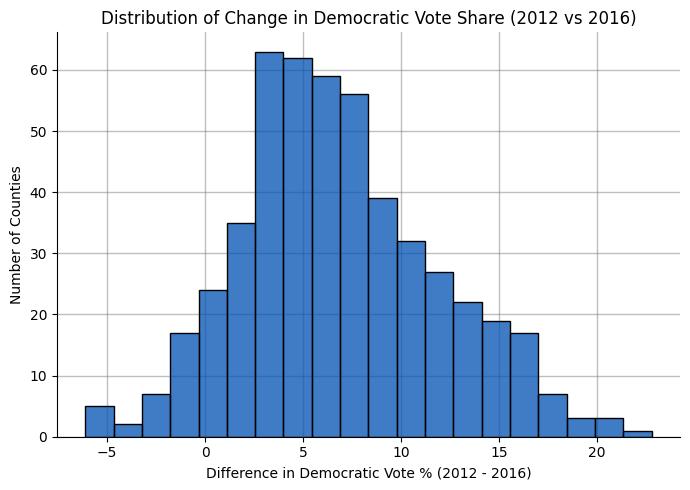

In [23]:
# Plot a histogram of the diff column with 20 bins.
fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(
    sample_dem_data["diff"], ax=ax, bins=20, color="#0050B3", edgecolor="black"
)
sns.despine()

ax.set(
    xlabel="Difference in Democratic Vote % (2012 - 2016)",
    ylabel="Number of Counties",
    title="Distribution of Change in Democratic Vote Share (2012 vs 2016)",
)
ax.grid(True, alpha=0.5, linewidth=1, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### Using ttest()
Manually calculating test statistics and transforming them with a CDF to get a p-value is a lot of effort to compare two sample means. The comparison of two sample means is called a t-test, and the `pingouin` Python package has a `.ttest()` method to accomplish it. This method provides some flexibility in how you perform the test.

As in the previous exercise, you'll explore the difference between the proportion of county-level votes for the Democratic candidate in 2012 and 2016 to identify if the difference is significant. The hypotheses are as follows:

$H_0$: The proportion of democratic votes in 2012 and 2016 were the same. <br>
$H_A$: The proportion of democratic votes in 2012 and 2016 were different.

In [27]:
# Conduct a t-test on the sample differences (the diff column of sample_dem_data), using an appropriate alternative hypothesis chosen from "two-sided", "less", and "greater".
import pingouin


test_results = pingouin.ttest(x=sample_dem_data["diff"], y=0, alternative="two-sided")

# Conduct a paired t-test on dem_percent_12 and dem_percent_16
paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided",
)

# Print the paired test results
display(paired_test_results)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.181565,998,two-sided,1.345737e-12,"[4.96, 8.7]",0.454202,4.308e+09,1.0
